# Classifying elliptic curves by complex multiplication

In [52]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from tqdm.notebook import *
from math import *
from livelossplot import PlotLosses
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn import tree
import matplotlib
import seaborn as sns
from helpers import *

In [2]:
df = pd.read_csv("output/dataset_unnormalized.csv")

In [3]:
df.head()

,A2,A3,A5,A7,A11,A13,A17,A19,A23,A29,...,A971,A977,A983,A991,A997,CONDUCTOR,L1,J,CM_RATIONAL,CM
0,0.0,2.0,1.0,-2.0,4.0,0.0,0.0,-4.0,2.0,6.0,...,21.0,-34.0,40.0,50.0,-61.0,448642.0,0.000000,-4.493062e+03,0.0,0.0
1,-1.0,0.0,1.0,-1.0,2.0,6.0,3.0,-4.0,6.0,-6.0,...,8.0,-38.0,11.0,-48.0,-24.0,142371.0,0.000000,-3.609741e+03,0.0,0.0
2,0.0,0.0,0.0,-2.0,4.0,0.0,2.0,-2.0,0.0,-6.0,...,20.0,32.0,-44.0,-4.0,-26.0,186108.0,1.960027,1.348249e+04,0.0,0.0
3,0.0,0.0,0.0,0.0,-4.0,-2.0,6.0,-2.0,4.0,0.0,...,24.0,-30.0,-48.0,52.0,-16.0,346400.0,0.615283,4.290156e+03,0.0,0.0
4,0.0,0.0,-2.0,2.0,2.0,-2.0,-6.0,-4.0,3.0,-8.0,...,-28.0,-8.0,-30.0,61.0,-48.0,95904.0,0.357066,-8.799209e+11,0.0,0.0


In [4]:
L1_ONLY = False
SOPHIE_GERMAIN = False
RUN_NN = False

In [5]:
if L1_ONLY:
    df = df[["L1","CM"]]
if not SOPHIE_GERMAIN:
    X = np.array(df)
    X = np.delete(X, len(X[0])-1, 1)
    Y = np.array(df["CM"])
    indexes = df.columns.values[:-1]
else:
    indexes=[]
    for x in df.columns.values:
        if x == "CM":
            continue
        if is_sg(int(x[1:])) or is_safe(int(x[1:])):
            indexes.append(x)
    X = np.array(df[indexes])
    Y = np.array(df["CM"])

In [6]:
X.shape

(5000, 172)

In [7]:
df["CM"]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4995    1.0
4996    1.0
4997    1.0
4998    1.0
4999    1.0
Name: CM, Length: 5000, dtype: float64

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, shuffle = True)
assert 0.4 < len(Y_train[Y_train==1])/len(Y_train) < 0.6, "Imbalanced train dataset"
assert 0.4 < len(Y_test[Y_test==1])/len(Y_test) < 0.6, "Imbalanced test dataset"

In [9]:
def ma_sampling(x: list, win = 28): # For pretty plots
    assert len(x)>win, "Window too large!"
    cur_sum = sum(x[:win])
    cur_pos = win - 1
    sampled = []
    for i in range(len(x)-win):
        sampled.append(cur_sum/win)
        cur_sum -= x[cur_pos-win]
        cur_pos += 1
        cur_sum += x[cur_pos]
    return sampled

In [10]:
def acc(X,Y):
    err_cnt = 0
    correct_cnt = 0
    for i in range(len(X)):
        x = torch.tensor(X[i], dtype=torch.double).float()
        y = Y[i]
        _y = model(x)
        if _y[0] > _y[1]:
            cls = 0
        else:
            cls = 1
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

## Neural network model

/usr/local/lib/python3.9/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


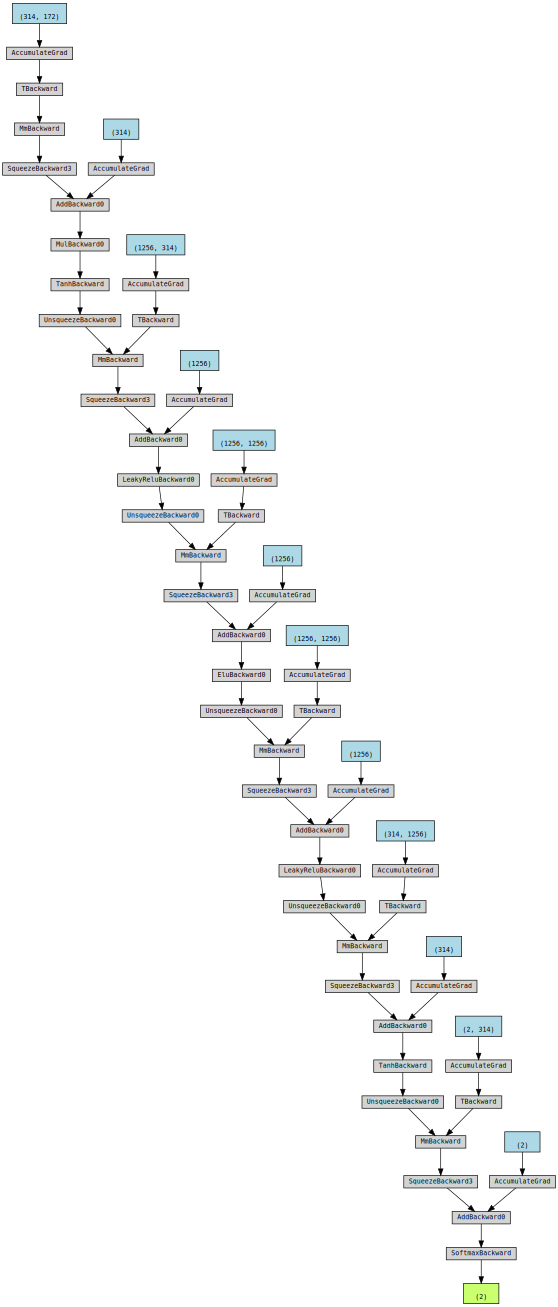

In [11]:
from torchviz import make_dot
DATA_SIZE = len(X[0])
N_EPOCHS = 2000
N_DISPLAY = 20
SAMPLE_SIZE = 100
A=314
k=4
model = nn.Sequential(
        nn.Linear(DATA_SIZE, A),
        nn.Dropout(0.1),
        nn.Tanh(),
        nn.Linear(A, k*A),
        nn.LeakyReLU(),
        nn.Linear(k*A, k*A),
        nn.ELU(),
        nn.Linear(k*A, k*A),
        nn.LeakyReLU(),
        nn.Linear(k*A, A),
        nn.Tanh(),
        nn.Linear(A, 2),
        nn.Softmax()
)
criterion = nn.CrossEntropyLoss() # The MOST inconvinient criterion ever!
optimizer = optim.SGD(model.parameters(), lr=0.01)
#print("Untrained accuracy(test): %.3f"%acc(X_test, Y_test))
#print("Untrained accuracy(train): %.3f"%acc(X_train, Y_train))
x = torch.tensor(X[0], dtype=torch.double).float()
y = model(x)
make_dot(y)

In [12]:
if RUN_NN:
    losses = []
    plotlosses = PlotLosses()
    avg_loss_lr = 0.0
    avg_accuracy = 0.0
    for i in tnrange(N_EPOCHS):
        indices = np.random.choice(X_train.shape[0], SAMPLE_SIZE, replace=False)
        sample_x = X_train[indices]
        sample_y = Y_train[indices]
        avg_loss = 0.0
        for j in range(SAMPLE_SIZE):
            x = torch.Tensor(sample_x[j])
            target = torch.Tensor([int(sample_y[j])]).type(torch.LongTensor)
            optimizer.zero_grad()   
            output = model(x)
            output = output.reshape((1,2)).float()
            loss = criterion(output, target)
            avg_loss += float(loss)
            loss.backward()
            optimizer.step()
        avg_loss /= SAMPLE_SIZE
        avg_loss_lr += avg_loss
        #avg_accuracy += acc(X_test, Y_test)
        if i % N_DISPLAY == 0 and i > 0:
            avg_loss_lr /= N_DISPLAY
            #avg_accuracy /= N_DISPLAY
            plotlosses.update({"Loss": avg_loss_lr, "Accuracy": acc(X_test, Y_test)})
            plotlosses.send()
            avg_loss_lr = 0.0
            avg_accuracy = 0.0
        losses.append(avg_loss)

In [13]:
if RUN_NN:
    plt.plot(ma_sampling(losses))
    plt.show()

In [14]:
print("Acc(train): %.3f"%acc(X_train, Y_train))
print("Acc(test): %.3f"%acc(X_test, Y_test))

/usr/local/lib/python3.9/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Acc(train): 0.537
Acc(test): 0.549


As it can be seen neural networks are absolutely useless for classifying _~~anything~~_ elliptic curves.

## Naive Bayesian classifier

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
naive_bayes = GaussianNB()
naive_bayes.fit(X_train , Y_train)
Y_predicted = naive_bayes.predict(X_test)
print("Acc: %.3f" % metrics.accuracy_score(Y_predicted , Y_test))

Acc: 0.541


In [16]:
X_train[0]

array([ 0.00000000e+00,  2.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        2.00000000e+00,  7.00000000e+00,  0.00000000e+00,  4.00000000e+00,
        4.00000000e+00,  6.00000000e+00,  8.00000000e+00,  3.00000000e+00,
        1.00000000e+01,  1.00000000e+00,  1.00000000e+01, -3.00000000e+00,
       -1.40000000e+01,  3.00000000e+00,  4.00000000e+00, -1.00000000e+01,
        4.00000000e+00, -7.00000000e+00, -6.00000000e+00,  5.00000000e+00,
        2.00000000e+00,  5.00000000e+00,  1.00000000e+00,  9.00000000e+00,
        1.70000000e+01, -2.10000000e+01,  1.20000000e+01, -1.10000000e+01,
        1.80000000e+01,  2.30000000e+01, -1.20000000e+01,  1.90000000e+01,
       -1.40000000e+01, -1.10000000e+01, -1.00000000e+00,  2.00000000e+00,
       -7.00000000e+00, -2.00000000e+00,  1.10000000e+01, -9.00000000e+00,
       -1.20000000e+01,  1.70000000e+01,  1.20000000e+01,  1.40000000e+01,
       -2.00000000e+01, -1.00000000e+01,  1.00000000e+01, -1.40000000e+01,
       -1.10000000e+01,  

## Convolutional neural network

In [17]:
if RUN_NN:
    model = nn.Sequential(
            nn.Conv1d(1, 1, 64),
            nn.MaxPool1d(8),
            nn.LeakyReLU(),
            nn.Linear(145,290),
            nn.Tanh(),
            nn.Linear(290,145),
            nn.LeakyReLU(),
            nn.Linear(145,2)
    )
    x = torch.tensor(X_train[0], dtype=torch.double).float().reshape((1,1,1229))

In [18]:
if RUN_NN:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

In [19]:
def acc(X,Y):
    err_cnt = 0
    correct_cnt = 0
    for i in range(len(X)):
        x = torch.tensor(X[i], dtype=torch.double).float().reshape((1,1,1229))
        y = Y[i]
        _y = model(x)
        if _y[0][0][0] > _y[0][0][1]:
            cls = 0
        else:
            cls = 1
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

In [20]:
if RUN_NN:    
    DATA_SIZE = len(X[0])
    N_EPOCHS = 800
    N_DISPLAY = 20
    SAMPLE_SIZE = 100
    losses = []
    plotlosses = PlotLosses()
    avg_loss_lr = 0.0
    avg_accuracy = 0.0
    for i in tnrange(N_EPOCHS):
        indices = np.random.choice(X_train.shape[0], SAMPLE_SIZE, replace=False)
        sample_x = X_train[indices]
        sample_y = Y_train[indices]
        avg_loss = 0.0
        for j in range(SAMPLE_SIZE):
            x = torch.Tensor(sample_x[j]).reshape((1,1,1229))
            target = torch.Tensor([int(sample_y[j])]).type(torch.LongTensor)
            optimizer.zero_grad()   
            output = model(x)
            output = output[0]
            loss = criterion(output, target)
            avg_loss += float(loss)
            loss.backward()
            optimizer.step()
        avg_loss /= SAMPLE_SIZE
        avg_loss_lr += avg_loss
        #avg_accuracy += acc(X_test, Y_test)
        if i % N_DISPLAY == 0 and i > 0:
            avg_loss_lr /= N_DISPLAY
            #avg_accuracy /= N_DISPLAY
            plotlosses.update({"Loss": avg_loss_lr, "Accuracy": acc(X_test, Y_test)})
            plotlosses.send()
            avg_loss_lr = 0.0
            avg_accuracy = 0.0
        losses.append(avg_loss)

In [21]:
if RUN_NN:    
    print("Acc(train): %.3f"%acc(X_train, Y_train))
    print("Acc(test): %.3f"%acc(X_test, Y_test))

Is this magic of random intialization?...or convolutional networks really suitable for working with big vectors? Anyway, lets save this network:

In [22]:
if RUN_NN:
    torch.save(model, "output/magic.th")

## Decision tree classifier


In [23]:
matplotlib.rc('figure', figsize=(20, 20))

In [24]:
model = tree.DecisionTreeClassifier()
model = model.fit(X_train, Y_train)

In [25]:
def acc(X,Y,fn):
    err_cnt = 0
    correct_cnt = 0
    for i in range(len(X)):
        x = X[i]
        y = Y[i]
        _y = fn([x])
        cls = _y[0]
        if round(y) != cls:
            err_cnt+=1
        else:
            correct_cnt+=1
    return correct_cnt/(correct_cnt+err_cnt)

In [26]:
accuracy = acc(X_test, Y_test, model.predict)
print("Accuracy:", accuracy)
print("N correct:%d/%d"%(round(len(X_test)*accuracy), len(X_test)))

Accuracy: 0.996
N correct:1494/1500


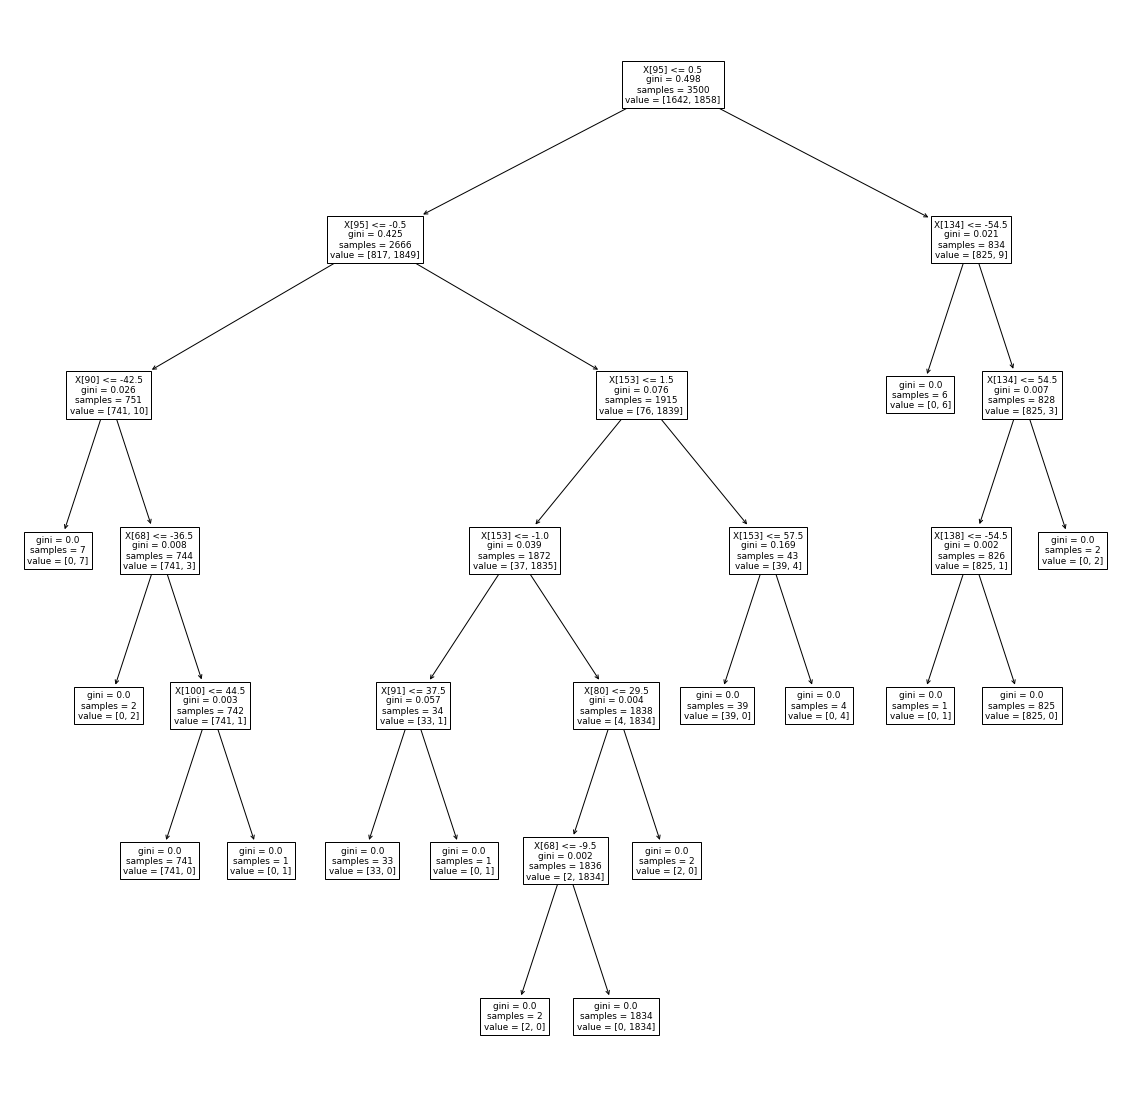

In [27]:
tree.plot_tree(model)
plt.plot(figsize=(10,10))
plt.show()

In [28]:
r = tree.export_text(model)

In [29]:
importances = list(model.feature_importances_)
for i in range(len(importances)):
    if importances[i] > 0.0:
        print(f"{indexes[i]} has importance {importances[i]}")

A347 has importance 0.0045740751056837226
A419 has importance 0.0022869657275709984
A467 has importance 0.007891703597541154
A479 has importance 0.0011134845739100402
A503 has importance 0.8947379116065136
A547 has importance 0.0011456804032953167
A761 has importance 0.009067779857908369
A797 has importance 0.0011458376365902172
A887 has importance 0.07803656149098655


## Bootstrap
Lets build tree many(e.g. 20) times and see which features would be most important and whether corresponiding index is Sophie-Germain prime or safe prime.

In [30]:
def bootstrap_best_feature():
    model = tree.DecisionTreeClassifier()
    model = model.fit(X_train, Y_train)
    importances = list(model.feature_importances_)
    best_feature_n = None
    best_score = 0.0
    for feature_n in range(len(importances)):
        if importances[feature_n] > best_score:
            best_score = importances[feature_n]
            best_feature_n = feature_n
    return best_feature_n, best_score

In [31]:
best_coefs = []
best_trees = []
n = 1000
n_sg = 0
n_safe = 0
total_score = 0.0
for i in tnrange(n):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, shuffle = True)
    n_feature, score = bootstrap_best_feature()
    total_score += score
    prime = int(indexes[n_feature][1:])
    if is_sg(prime):
        n_sg += 1
    if is_safe(prime):
        n_safe += 1
    accuracy = acc(X_test, Y_test, model.predict)
    if accuracy == 1.0:
        best_trees.append(model)
    best_coefs.append(prime)
print(f"n_sg={n_sg}")
print(f"n_safe={n_safe}")
print(f"avg_score={total_score/n}")

  0%|          | 0/1000 [00:00<?, ?it/s]

n_sg=20
n_safe=973
avg_score=0.9140956492483316


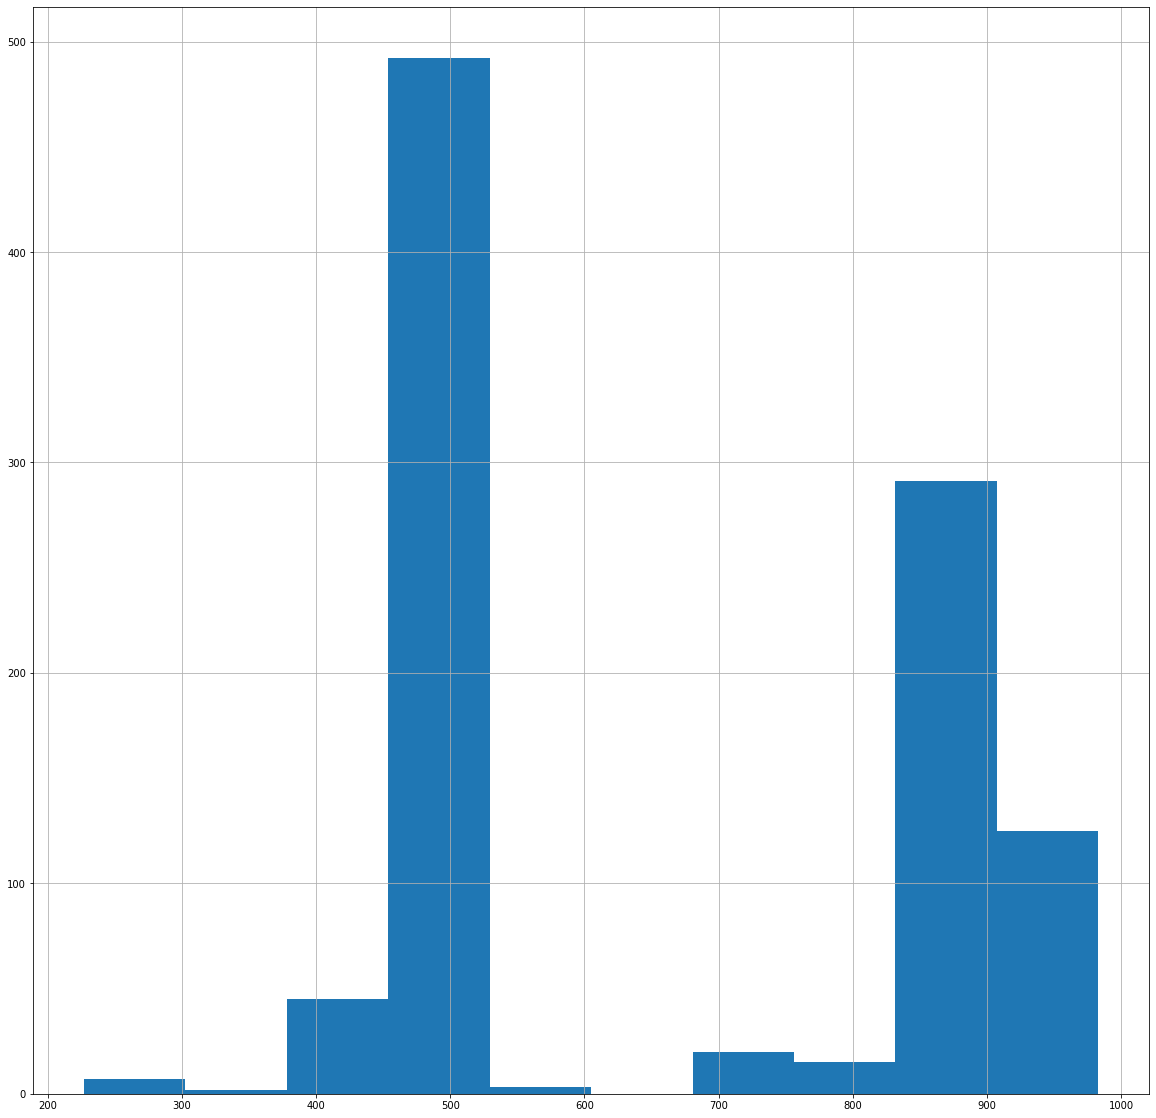

In [32]:
plt.hist(best_coefs)
plt.grid()
plt.show()

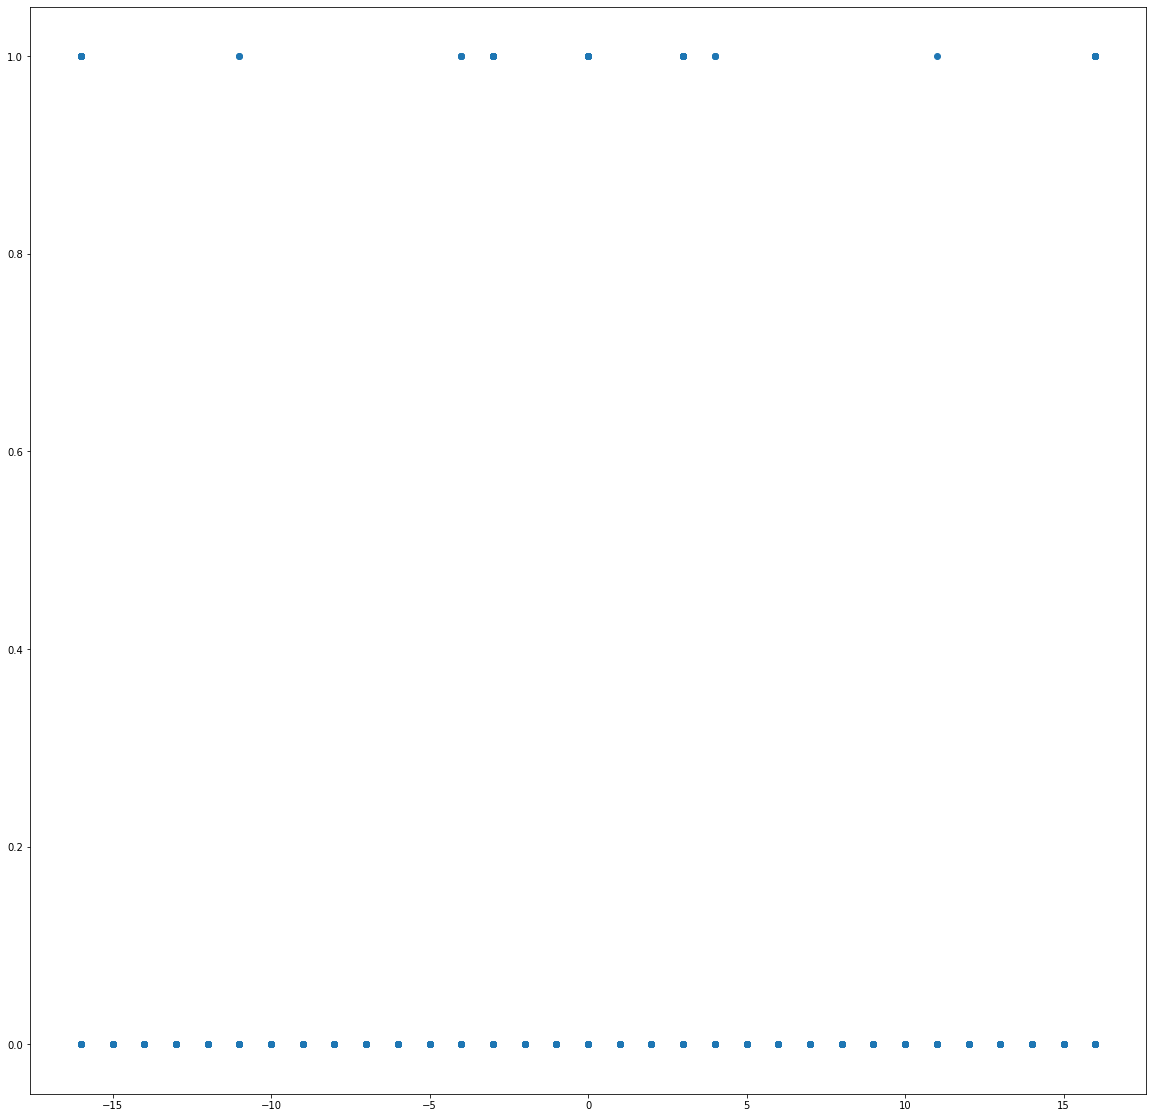

In [33]:
plt.scatter(df["A71"], df["CM"])
plt.show()

In [34]:
t = df[df["CM"]==0.0]

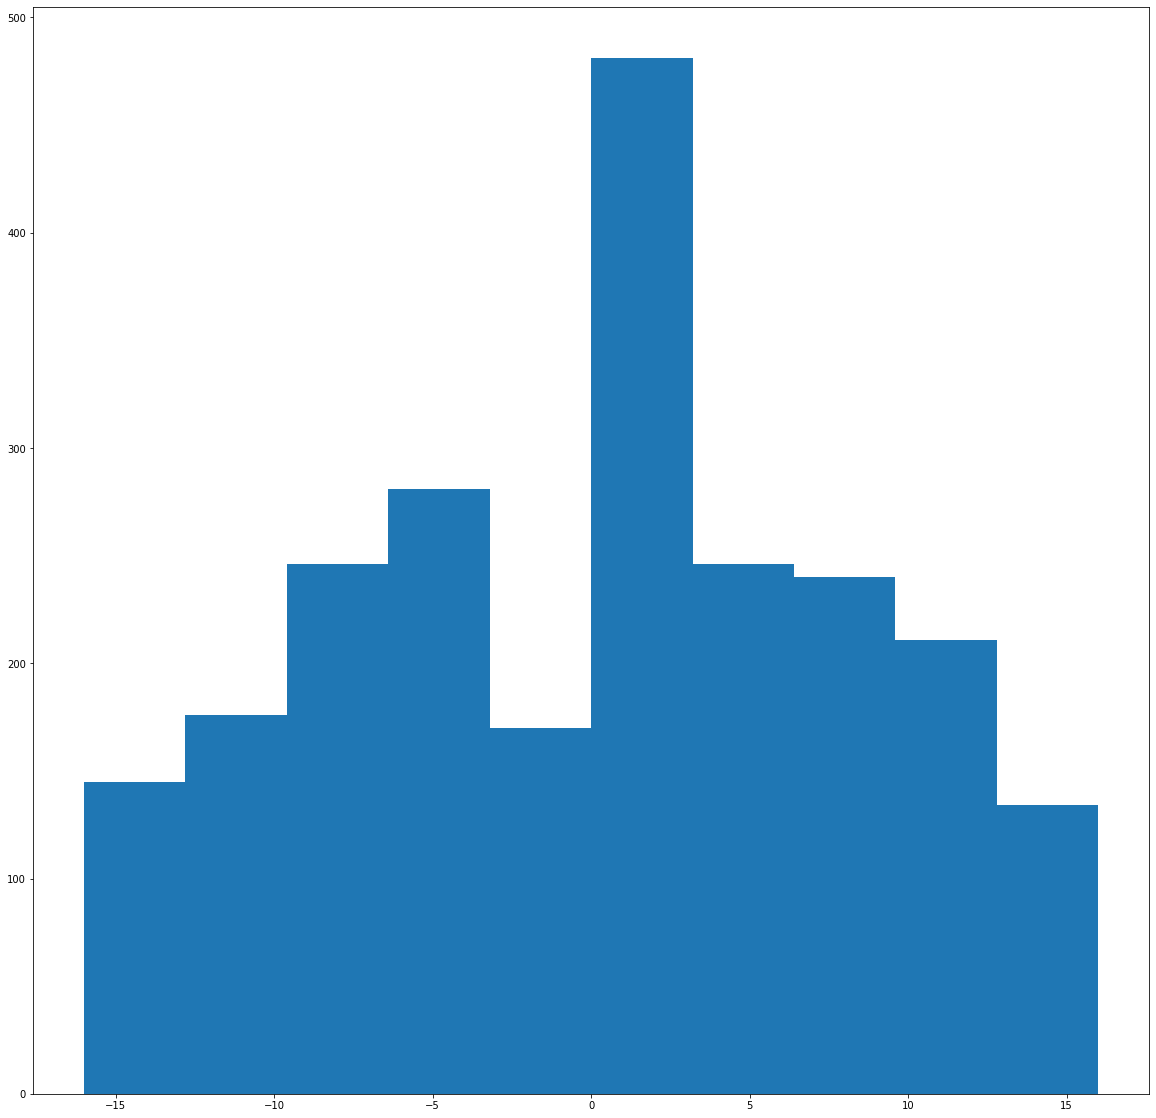

In [35]:
plt.hist(t["A71"])
plt.show()

<p>We can see that only 8 curve are classified incorrectly: they are said to be CM while they are not. This is exactly why tree adds additional conditions. It would be quite intresting to note that value of some $a_p$ being equal $0$ also means that elliptic curve singular in field modulo $p$. So we can predict that using random forest of trees built on different splits may increase accuracy up to $100\%$.<p>
<p>Using previously obtained data we can note that there is some coefficient which are zero when curve has CM.</p> 

**Conjecture(strong)**:
<br>
There is an infinite subset of primes $C\subset P$, s.t. for any elliptic curve $E$:
$$
\displaystyle
\forall p\in C: a_p=0 \Rightarrow E\in CM
$$
* $a_p$ is coefficients of Hasse-Weil $L$-function for 
* $CM$ set of elliptic curves with $CM$

## $L(E,1)$ 

As BSD conjecture suggests the elliptic curve rank can depend on $L$-function at point $1$.

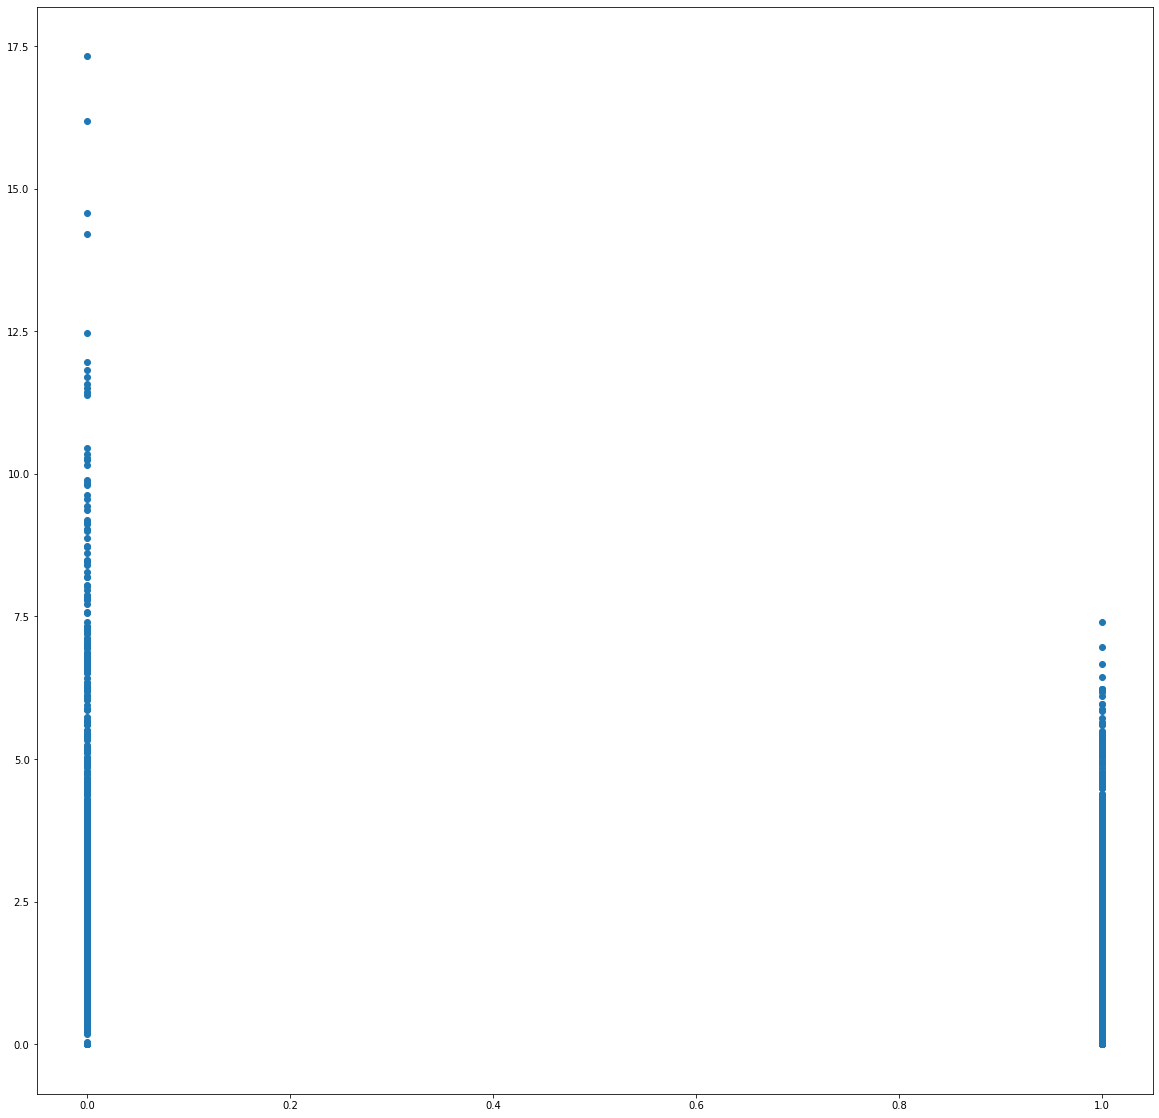

In [37]:
plt.scatter(df["CM"], df["L1"])
plt.show()

In [38]:
model = tree.DecisionTreeClassifier()
model = model.fit(X_train, Y_train)

In [39]:
accuracy = acc(X_test, Y_test, model.predict)
print("Accuracy:", accuracy)
print("N correct:%d/%d"%(round(len(X_test)*accuracy), len(X_test)))

Accuracy: 0.9936
N correct:2484/2500


## $j$-invariant analysis

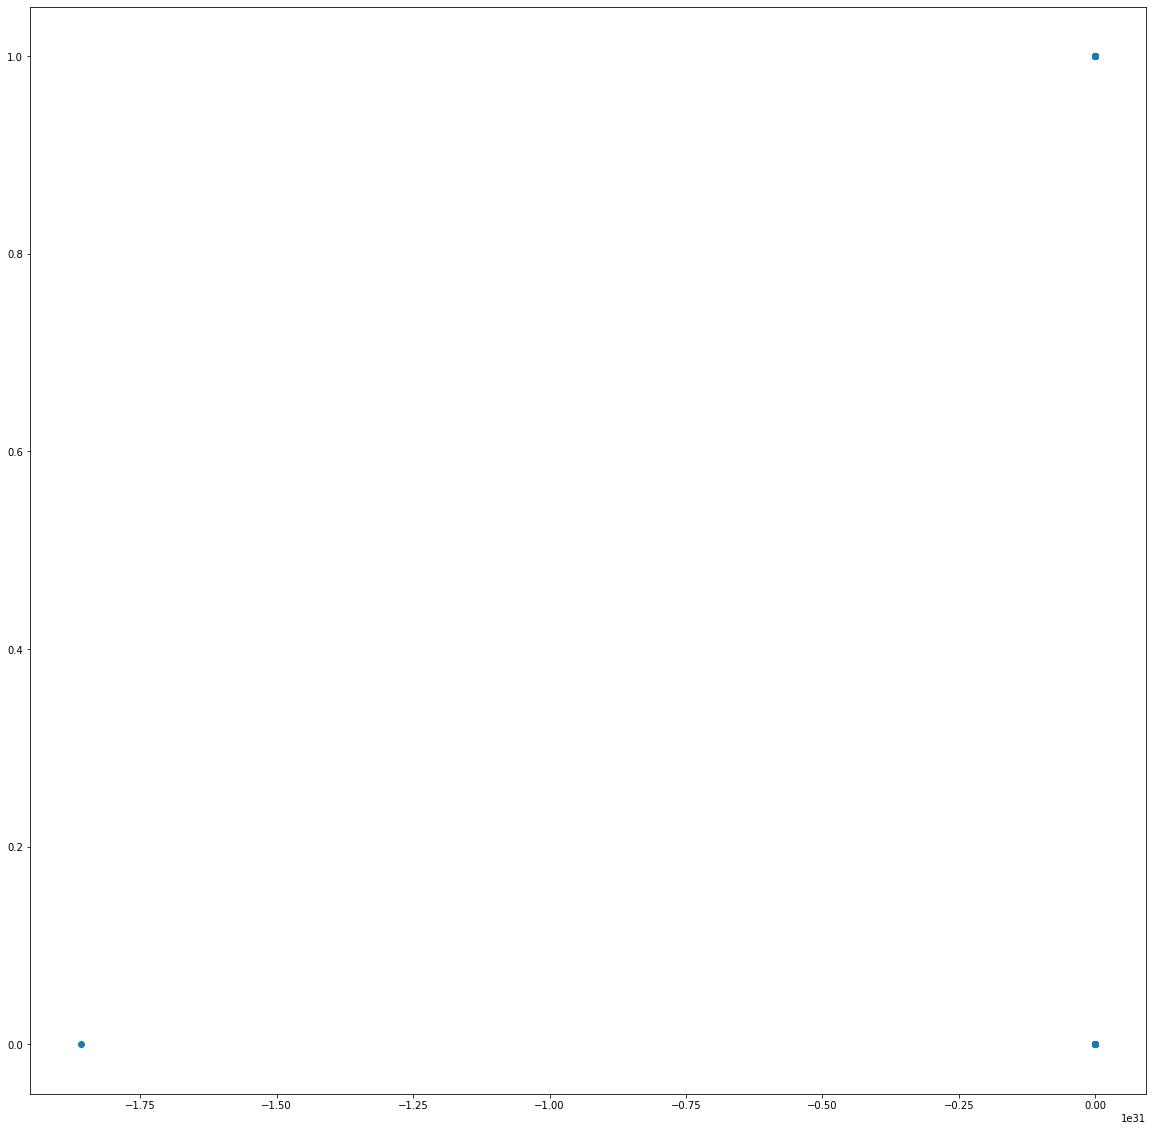

In [40]:
plt.scatter(df["J"], df["CM"])
plt.show()

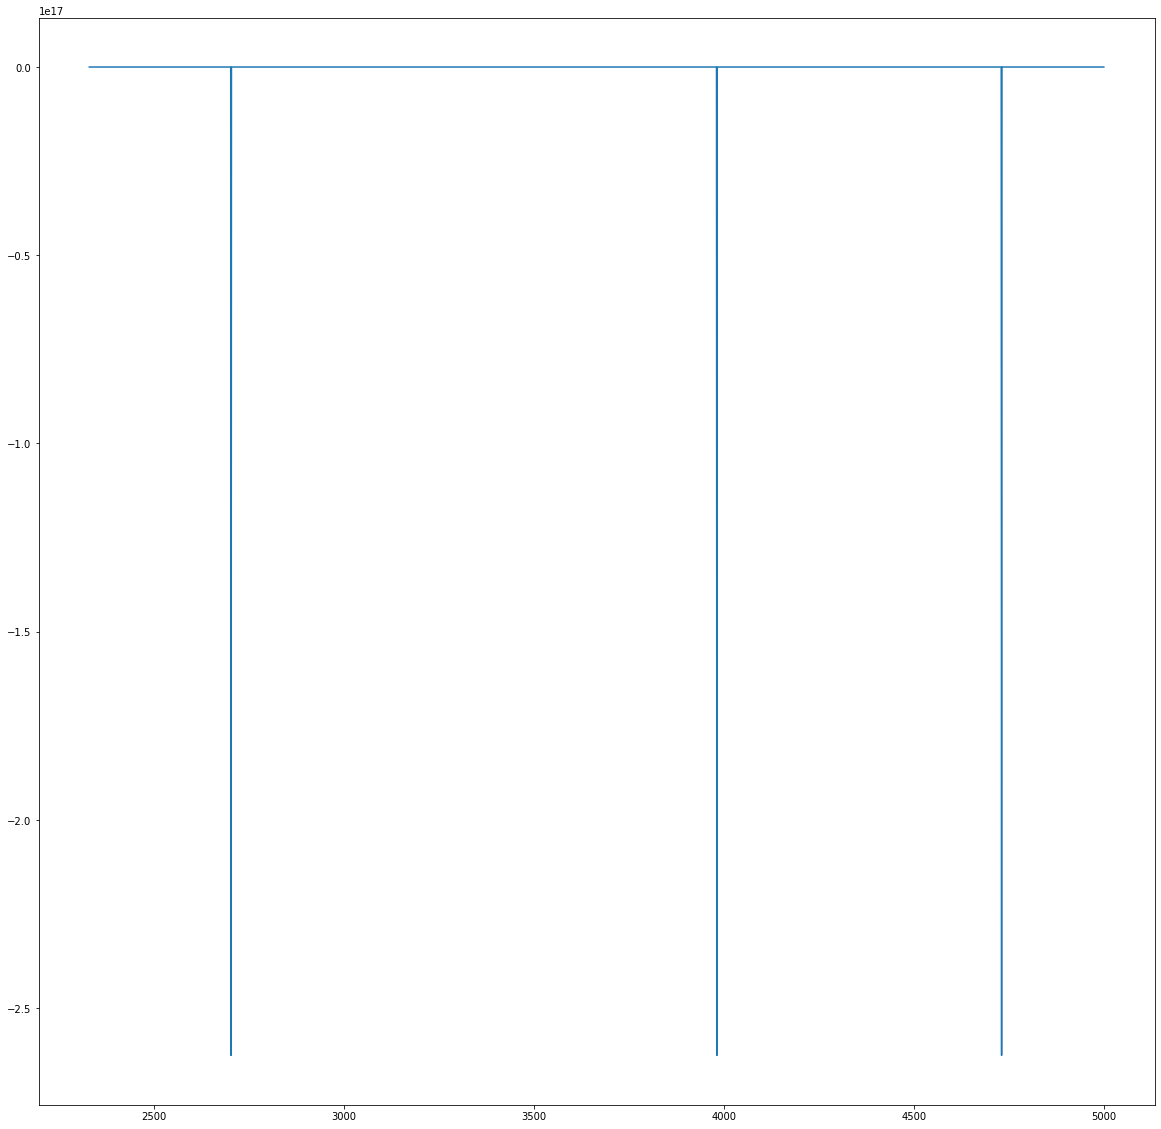

In [41]:
plt.plot(df[df["CM"]==1]["J"])
plt.show()

In [42]:
j_CM = set(df[df["CM"]==1]["J"])
j_CM

{-2.62537412640768e+17,
 -147197952000.0,
 -884736000.0,
 -884736.0,
 -32768.0,
 -3375.0,
 0.0,
 1728.0,
 8000.0}

In [43]:
j_nonCM = set(df[df["CM"]==0]["J"])
j_nonCM

{335872.98820004024,
 -1589248.1236449496,
 2.5382723883556757,
 2.301639344262295,
 -8188.753147440082,
 5.109691935809295,
 66871301.78693215,
 7.53626010170947,
 7.029488901693451,
 24584.87101029221,
 8.90945697754957,
 11.12270150148239,
 12.381041982871029,
 13.901530274538263,
 12.140792886254168,
 15.16398358003866,
 15.67161182466539,
 -57330.95502431189,
 19.405775870944076,
 19.6942424164524,
 21.049219919999217,
 1392662.349071504,
 23.00144073346431,
 22.59391537490837,
 25.517030738502275,
 26.916743366466743,
 27.14027904097609,
 22.484499324653683,
 29.569961272941573,
 29.45430494234687,
 23.45288794103672,
 3137559.9113719505,
 33.95501900178298,
 33.43799841263842,
 33.06682613245627,
 34.13413808668115,
 37.38377842038064,
 38.23245072322777,
 33.42425775751033,
 -483294.8480076036,
 41.300104448088135,
 42.75716820866988,
 43.09744134013516,
 41.47054297526154,
 44.7841890168765,
 46.46052047828085,
 48.00005523142708,
 48.1401206239502,
 50.5726797631586,
 51.9369

## Can we use $j$-invariant to predict the CM?
BSD conjecture says that yes, lets verify that:

In [44]:
for x in j_CM:
    print(f"Is {x} in non-CM?", x in j_nonCM)

Is 0.0 in non-CM? False
Is 8000.0 in non-CM? False
Is -32768.0 in non-CM? False
Is 1728.0 in non-CM? False
Is -884736.0 in non-CM? False
Is -884736000.0 in non-CM? False
Is -147197952000.0 in non-CM? False
Is -2.62537412640768e+17 in non-CM? False
Is -3375.0 in non-CM? False


There is no need to build any model: the sets of $j$-invariants are well-splitted, so for this data set second corrollary of BSD conjecture works.

In [69]:
is_safe(511)

False

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


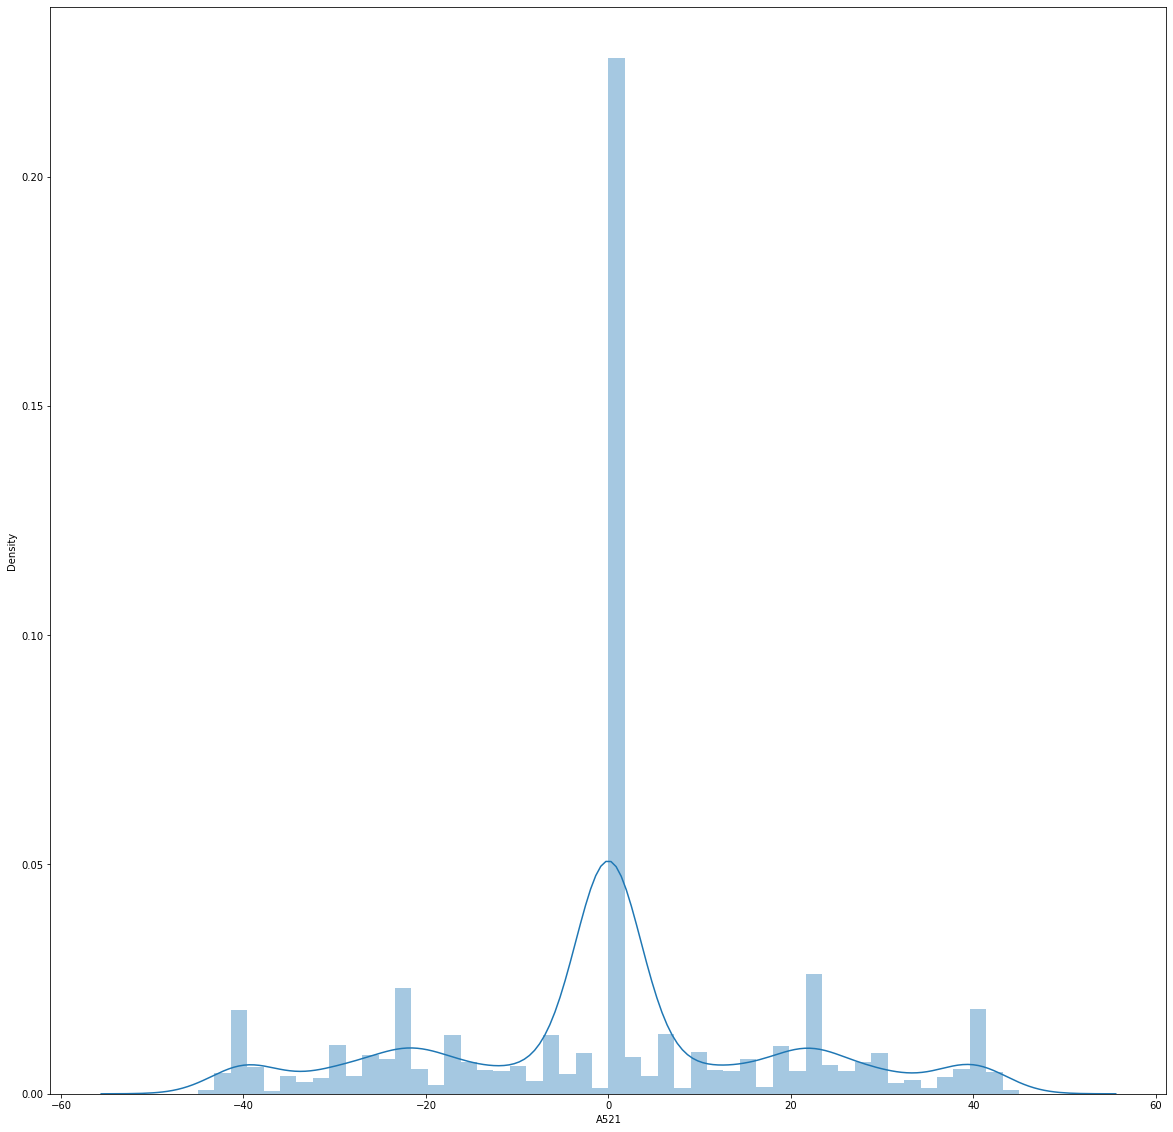

In [81]:
sns.distplot(df["A521"])
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


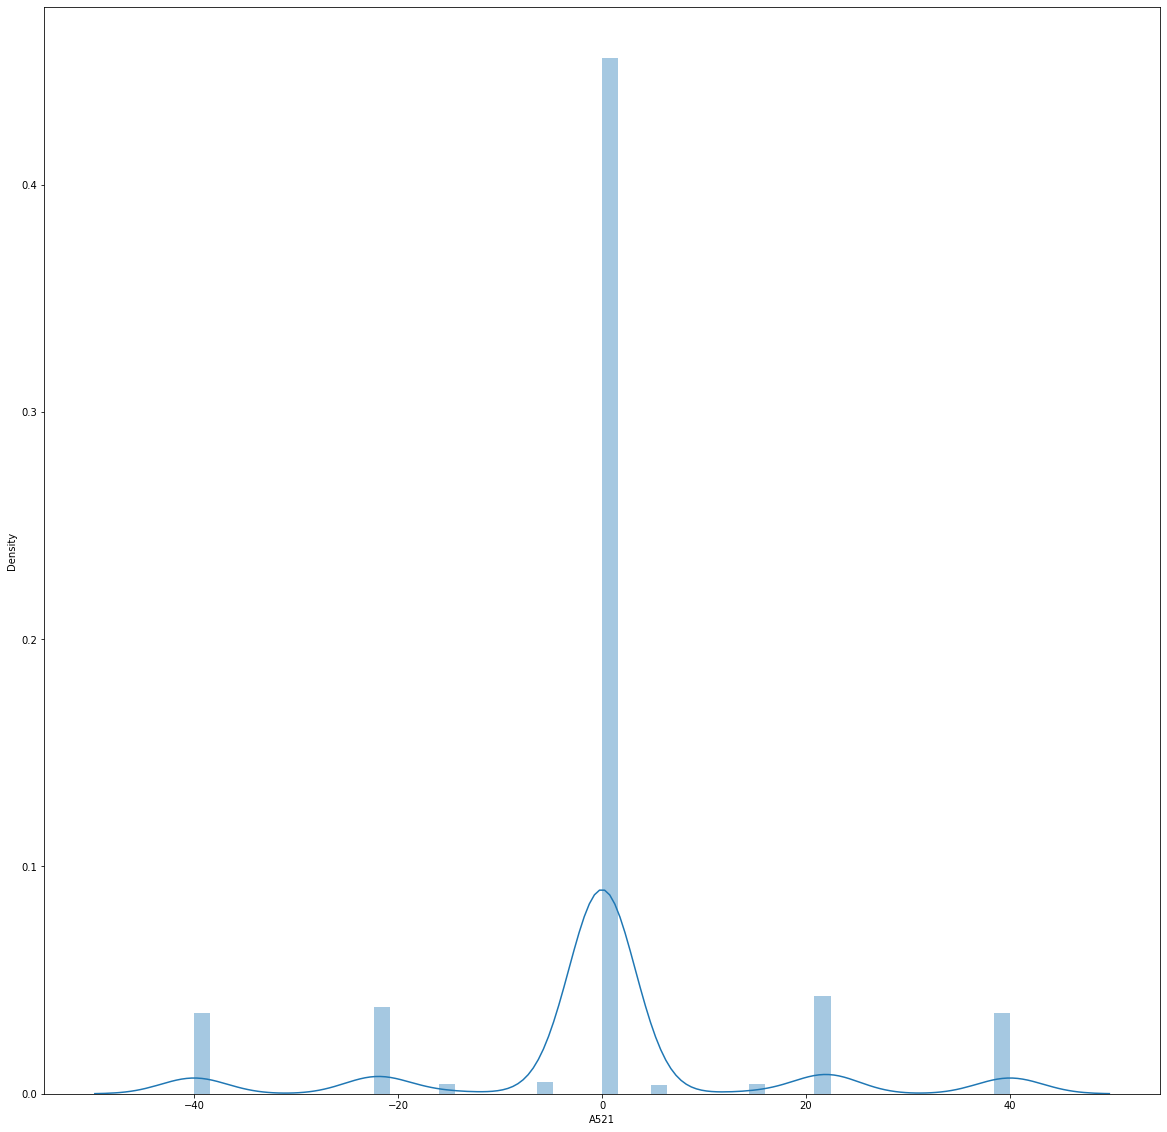

In [84]:
sns.distplot(df[df["CM"]==1]["A521"])
plt.show()

In [83]:
len(df[df["A521"]==0])

2018

In [77]:
is_sg(521)

False